In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import warnings
import plotly.express as px

warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.facecolor'] = 'white'

# Color palette for status
STATUS_COLORS = {
    'Passed into Law': '#d62728',  # Red - danger
    'Advancing': '#ff7f0e',         # Orange - warning
    'Introduced': '#ffbb78',        # Light orange
    'Defeated': '#2ca02c',          # Green - success
}

print("✅ Setup complete")

✅ Setup complete


1. All LegiScan Bills (2025-2026)

In [2]:
all_bills_df = pd.read_csv('../legiscan-bulk-csv/concatenated-2025-2026/all-bills.csv')
print(f"Loaded {len(all_bills_df)} records")
print(f"Columns: {list(all_bills_df.columns)}")
all_bills_df.head()

Loaded 142696 records
Columns: ['bill_id', 'session_id', 'bill_number', 'status', 'status_desc', 'status_date', 'title', 'description', 'committee_id', 'committee', 'last_action_date', 'last_action', 'url', 'state_link', 'state']


,bill_id,session_id,bill_number,status,status_desc,status_date,title,description,committee_id,committee,last_action_date,last_action,url,state_link,state
0,1904940,2195,H0001,4,Passed,2025-06-05,An act relating to accepting and referring complaints by the State Ethics Commission,An act relating to accepting and referring complaints by the State Ethics Commission,0,NaN,2025-06-09,"House message: Governor allowed to become law without signature on June 5, 2025",https://legiscan.com/VT/bill/H0001/2025,https://legislature.vermont.gov/bill/status/2026/H.1,VT
1,1905031,2195,H0002,4,Passed,2025-04-01,An act relating to increasing the minimum age for delinquency proceedings,An act relating to increasing the minimum age for delinquency proceedings,0,NaN,2025-04-02,"House message: Governor approved bill on March 31, 2025",https://legiscan.com/VT/bill/H0002/2025,https://legislature.vermont.gov/bill/status/2026/H.2,VT
2,1905076,2195,H0003,1,Introduced,2025-01-09,An act relating to the minimum qualifications required for State employment,An act relating to the minimum qualifications required for State employment,4658,House Government Operations and Military Affairs,2025-01-09,Read first time and referred to the Committee on Government Operations and Military Affairs,https://legiscan.com/VT/bill/H0003/2025,https://legislature.vermont.gov/bill/status/2026/H.3,VT
3,1905008,2195,H0004,1,Introduced,2025-01-09,An act relating to standards for the care of egg-laying hens,An act relating to standards for the care of egg-laying hens,4753,"House Agriculture, Food Resiliency, and Forestry",2025-01-09,"Read first time and referred to the Committee on Agriculture, Food Resiliency, and Forestry",https://legiscan.com/VT/bill/H0004/2025,https://legislature.vermont.gov/bill/status/2026/H.4,VT
4,1905211,2195,H0005,1,Introduced,2025-01-09,An act relating to a hearsay exception for a child under 16 years of age,An act relating to a hearsay exception for a child under 16 years of age,790,House Judiciary,2025-01-09,Read first time and referred to the Committee on Judiciary,https://legiscan.com/VT/bill/H0005/2025,https://legislature.vermont.gov/bill/status/2026/H.5,VT


In [3]:
# Bill counts by status_desc (raw LegiScan values)
status_counts = all_bills_df['status_desc'].value_counts(dropna=False)
print("Bill counts by status_desc:\n")
print(status_counts.to_string())

Bill counts by status_desc:

status_desc
Introduced    111659
Passed         20902
Engrossed       7523
Failed          1178
NaN              640
Enrolled         405
Vetoed           389


In [4]:
# Map status_desc to categories
# Engrossed = pass one chamber -> second chamber (house or senate)
# Enrolled = pass both chambers -> governor signature
STATUS_GROUPS = {
    'Introduced': ['Introduced'],
    'Advancing': ['Engrossed', 'Enrolled'],
    'Passed': ['Passed'],
    'Defeated': ['Failed', 'Vetoed'],
}

def map_status(status_desc):
    if pd.isna(status_desc) or str(status_desc).strip() == '':
        return 'Other/Unknown'
    s = str(status_desc).strip()
    for group, values in STATUS_GROUPS.items():
        if s in values:
            return group
    return 'Other/Unknown'

all_bills_df['status_group'] = all_bills_df['status_desc'].apply(map_status)
group_counts = all_bills_df['status_group'].value_counts()
# Order: Introduced, Advancing, Passed, Defeated, Other/Unknown
order = ['Introduced', 'Advancing', 'Passed', 'Defeated', 'Other/Unknown']
group_counts = group_counts.reindex([c for c in order if c in group_counts.index]).fillna(0).astype(int)
print("Bill counts by status group:\n")
print(group_counts.to_string())

Bill counts by status group:

status_group
Introduced       111659
Advancing          7928
Passed            20902
Defeated           1567
Other/Unknown       640


In [5]:
# Drop rows with status_group = 'Introduced' to reduce scope
# Looking at bills that matter
all_bills_df = all_bills_df[all_bills_df['status_group'] != 'Introduced']
print(f"After dropping Introduced: {len(all_bills_df)} records")

After dropping Introduced: 31037 records


<Axes: xlabel='status_group'>

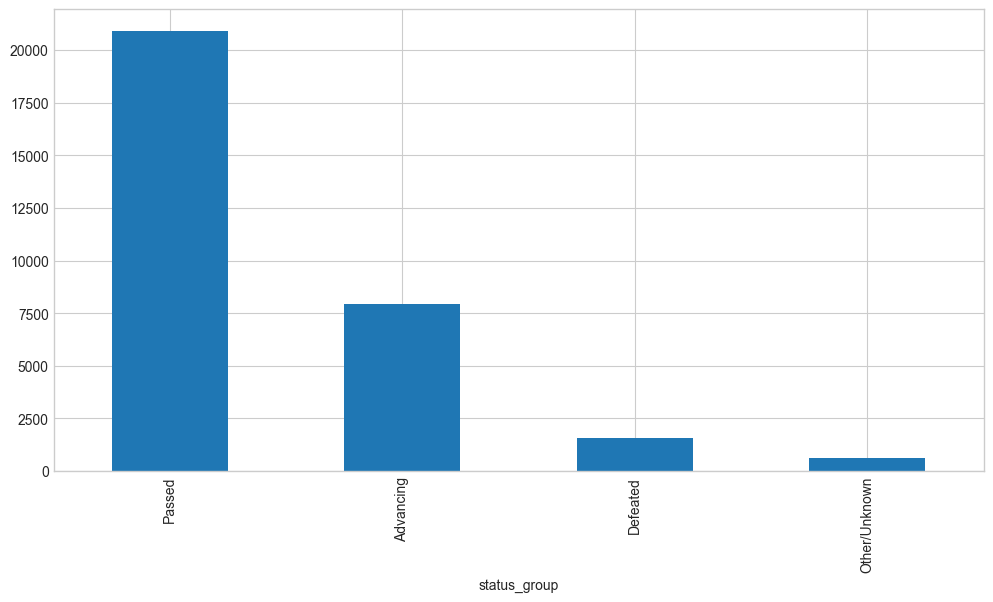

In [6]:
all_bills_df['status_group'].value_counts().plot(kind='bar')

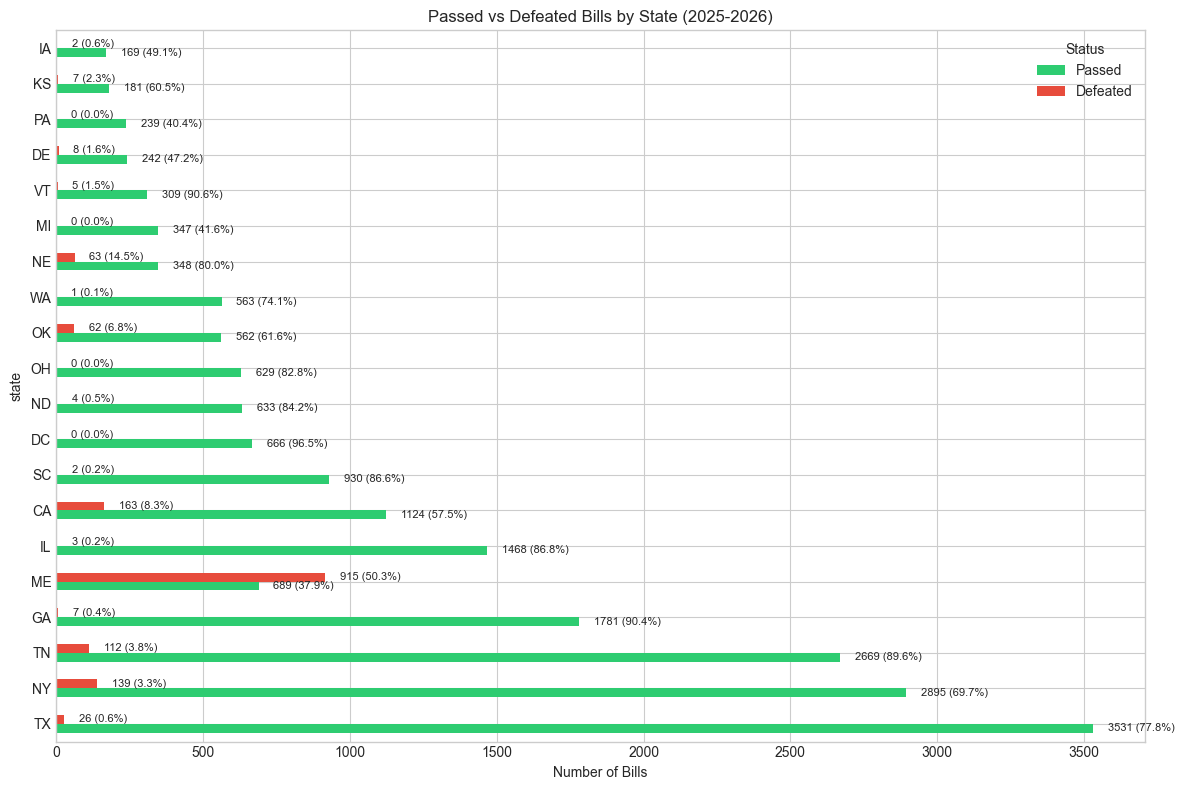

In [7]:
# Get counts and percentages
state_counts = pd.crosstab(all_bills_df['state'], all_bills_df['status_group'])
state_pcts = state_counts.div(state_counts.sum(axis=1), axis=0) * 100

# Filter to Passed/Defeated, sort by total activity
plot_df = state_counts[['Passed', 'Defeated']].copy()
plot_df['Total'] = plot_df.sum(axis=1)
plot_df = plot_df.sort_values(
    'Total', ascending=False).head(20).drop(columns='Total')

fig, ax = plt.subplots(figsize=(12, 8))
plot_df.plot(kind='barh', ax=ax, color=['#2ecc71', '#e74c3c'])

# Add count + percentage labels
for i, state in enumerate(plot_df.index):
    for j, col in enumerate(['Passed', 'Defeated']):
        count = plot_df.loc[state, col]
        pct = state_pcts.loc[state, col]
        ax.annotate(f'{count} ({pct:.1f}%)',
                    xy=(count + 50, i + (j - 0.5) * 0.25),
                    fontsize=8, va='center')

ax.set_xlabel('Number of Bills')
ax.set_title('Passed vs Defeated Bills by State (2025-2026)')
ax.legend(title='Status')
plt.tight_layout()

<Axes: xlabel='month'>

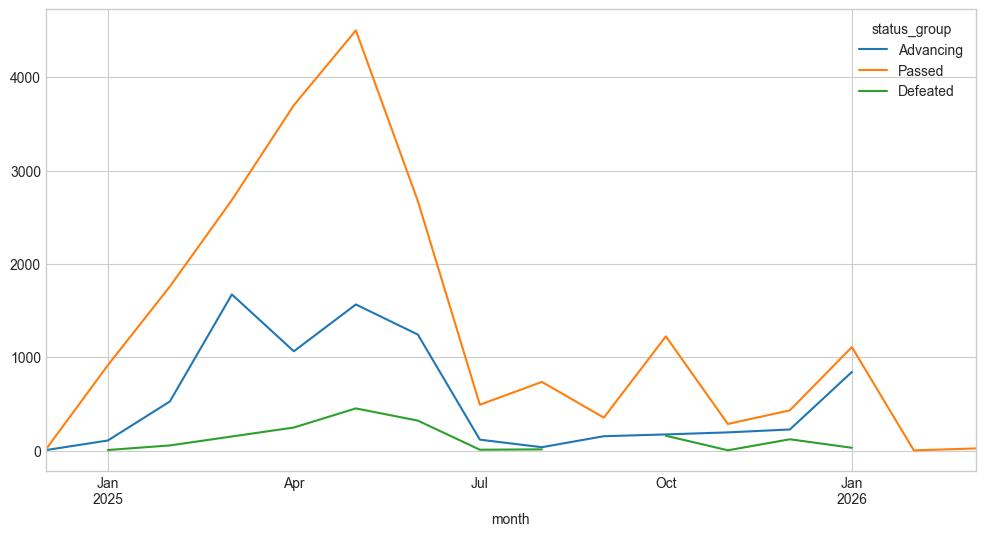

In [8]:
all_bills_df['status_date'] = pd.to_datetime(all_bills_df['status_date'])
all_bills_df['month'] = all_bills_df['status_date'].dt.to_period('M')

# Activity over time by status
all_bills_df.groupby(['month', 'status_group']).size().unstack().plot()

In [9]:
# Which committees see the most action?
all_bills_df['committee'].value_counts().head(20)

committee
Senate Rules and Operations of the Senate             207
Senate Judiciary                                      185
Senate Assignments                                    156
Senate Education                                      148
Senate Transportation                                 134
House Rules                                           128
Senate Finance                                        119
Senate Local Government                               119
Senate Rules                                           97
Assembly Budget                                        92
Senate Health                                          92
Senate Budget and Fiscal Review                        90
House Judiciary                                        76
Senate Ways and Means                                  74
Assembly Appropriations                                70
House Finance                                          64
House Appropriations                                   56
Sena

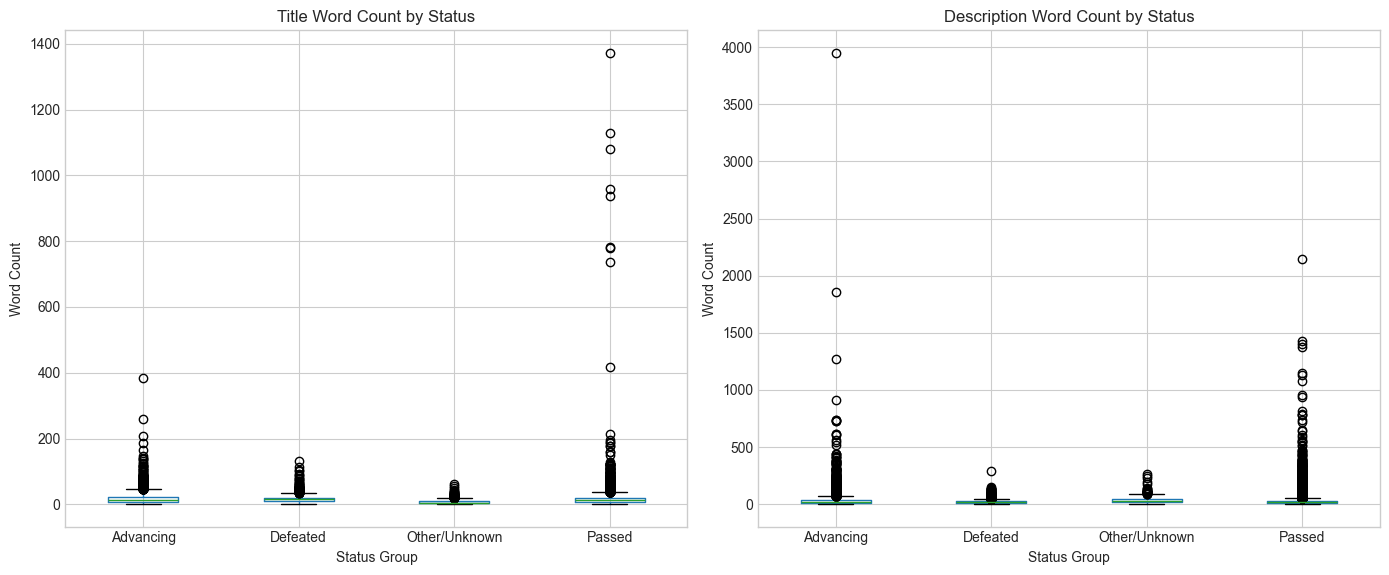

In [10]:
all_bills_df['title_words'] = all_bills_df['title'].str.split().str.len()
all_bills_df['desc_words'] = all_bills_df['description'].str.split().str.len()

# Title and description word count by status
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

all_bills_df.boxplot(column='title_words', by='status_group', ax=axes[0])
axes[0].set_title('Title Word Count by Status')
axes[0].set_xlabel('Status Group')
axes[0].set_ylabel('Word Count')

all_bills_df.boxplot(column='desc_words', by='status_group', ax=axes[1])
axes[1].set_title('Description Word Count by Status')
axes[1].set_xlabel('Status Group')
axes[1].set_ylabel('Word Count')

plt.suptitle('')
plt.tight_layout()
plt.show()

In [11]:
lgbtq_keywords = r'|'.join([
    # Direct terms
    r'transgender', r'gender identity', r'sexual orientation', r'lgbtq',
    r'same-sex', r'\bgay\b', r'lesbian', r'nonbinary', r'queer',

    # Healthcare / trans care
    r'gender.?affirming', r'puberty block', r'hormone (therapy|treatment)',
    r'sex change', r'gender transition', r'sex reassignment', r'cross-sex',

    # Sports / bathrooms
    r'biological (sex|male|female)', r'sex assigned', r'birth.?sex',
    r'female.{0,15}sport', r'women.{0,10}athlet', r'sex.?designated',
    r'single.?sex', r'male.{0,10}female.{0,10}(facility|bathroom|restroom|locker)',

    # Education / pronouns
    r'preferred pronoun', r'chosen name', r'parental.{0,10}(rights|consent|notification)',
    r'(classroom|school).{0,20}(gender|sex)', r'(gender|sex).{0,10}curriculum',

    # Identity documents
    r'birth certificate.{0,20}(sex|gender)', r'gender marker',

    # Family / adoption
    r'(adoption|foster).{0,20}(religious|conscience|faith)',

    # Religious exemptions (often anti-LGBTQ+)
    r'religious freedom restoration', r'conscience protection', r'sincerely held belief',

    # Drag / performance
    r'drag (queen|king|performance|show)', r'male.{0,5}female impersonat',

    # Conversion therapy
    r'conversion therapy', r'reparative therapy', r'sexual orientation change',

    # Legal definitions
    r'(definition|define).{0,15}(sex|male|female|man|woman)',
    r'\b(sex)\b.{0,10}(mean|shall mean|is defined)',
])

all_bills_df['lgbtq_flag'] = (
    all_bills_df['title'].str.contains(lgbtq_keywords, case=False, na=False, regex=True) |
    all_bills_df['description'].str.contains(
        lgbtq_keywords, case=False, na=False, regex=True)
)

print(f"Potentially relevant bills: {all_bills_df['lgbtq_flag'].sum()}")

Potentially relevant bills: 119


In [12]:
# Preview flagged bills
flagged = all_bills_df[all_bills_df['lgbtq_flag']][[
    'state', 'title', 'description', 'status_group']]
print(flagged.sample(20))  # Spot check for false positives

              state  \
52995   US-Congress   
73796            TX   
9722             GA   
93798            NE   
96717            HI   
138762           TN   
96880            HI   
88756            ME   
110371           NY   
92704            KS   
137719           TN   
88829            ME   
102126           NY   
45740            CA   
46278            CA   
140566           TN   
96715            HI   
136924           TN   
23581            MA   
2903             VA   

                                                                                                      title  \
52995                                                                            Do No Harm in Medicaid Act   
73796                                                      Relating to parental rights in public education.   
9722    Employees' Insurance and Benefits Plans; expenses for gender-affirming care under the state heal...   
93798   Adopt the Parental Rights in Social Media Act, rename the Child 

In [13]:
print(f"Total bills: {len(all_bills_df)}")
print(f"LGBTQ+ flagged: {all_bills_df['lgbtq_flag'].sum()}")
print(f"Percentage: {all_bills_df['lgbtq_flag'].mean() * 100:.2f}%")

Total bills: 31037
LGBTQ+ flagged: 119
Percentage: 0.38%


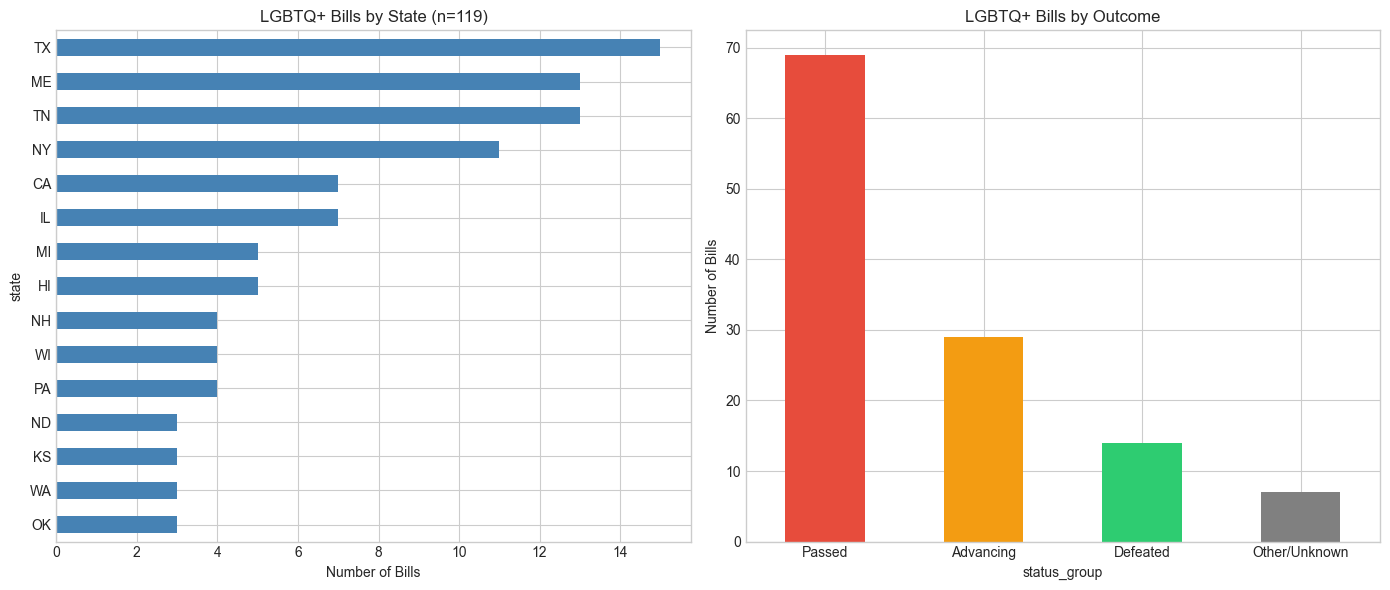

In [14]:
lgbtq_bills = all_bills_df[all_bills_df['lgbtq_flag']].copy()

# --- Figure 1: Overview charts ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# State distribution
state_counts = lgbtq_bills['state'].value_counts().head(15)
state_counts.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title(f'LGBTQ+ Bills by State (n={len(lgbtq_bills)})')
axes[0].set_xlabel('Number of Bills')
axes[0].invert_yaxis()

# Status distribution
status_counts = lgbtq_bills['status_group'].value_counts()
colors = {'Passed': '#e74c3c', 'Defeated': '#2ecc71', 'Advancing': '#f39c12'}
status_counts.plot(kind='bar', ax=axes[1], color=[
                   colors.get(s, 'gray') for s in status_counts.index])
axes[1].set_title('LGBTQ+ Bills by Outcome')
axes[1].set_ylabel('Number of Bills')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [15]:
# Clean table for inspection
lgbtq_summary = lgbtq_bills[['state', 'bill_number',
                             'status_group', 'title', 'description']].copy()
lgbtq_summary['title_short'] = lgbtq_summary['title'].str[:80] + '...'
lgbtq_summary['desc_short'] = lgbtq_summary['description'].str[:100] + '...'

# Sort by state then status
lgbtq_summary = lgbtq_summary.sort_values(['state', 'status_group'])

# Display
lgbtq_summary[['state', 'bill_number', 'status_group', 'title_short']].head(30)

,state,bill_number,status_group,title_short
25235,AL,HB161,Advancing,"Consumer protection, app store providers and developers required to take certain..."
45740,CA,SB418,Defeated,Health care coverage: prescription hormone therapy and nondiscrimination....
44937,CA,AB1487,Passed,"Public health: Two-Spirit, Transgender, Gender Nonconforming, and Intersex Welln..."
45096,CA,AR21,Passed,Relative to Transgender Day of Visibility....
45118,CA,AR43,Passed,"Relative to Lesbian, Gay, Bisexual, Transgender, and Queer (LGBTQ+) Pride Month...."
45132,CA,AR57,Passed,Relative to Transgender History Month....
46252,CA,SR22,Passed,Relative to Transgender Day of Visibility....
46278,CA,SR48,Passed,"Relative to Lesbian, Gay, Bisexual, Transgender, and Queer (LGBTQ+) Pride Month...."
91040,DC,CER26-0105,Passed,Transgender Day of Remembrance Recognition Resolution of 2025...
99884,DE,HCR22,Advancing,Recognizing March 31st As International Transgender Day Of Visibility In The Sta...


In [16]:
fig = px.treemap(lgbtq_bills,
                 path=['status_group', 'state'],
                 title='LGBTQ+ Bills: Status → State')
fig.show()

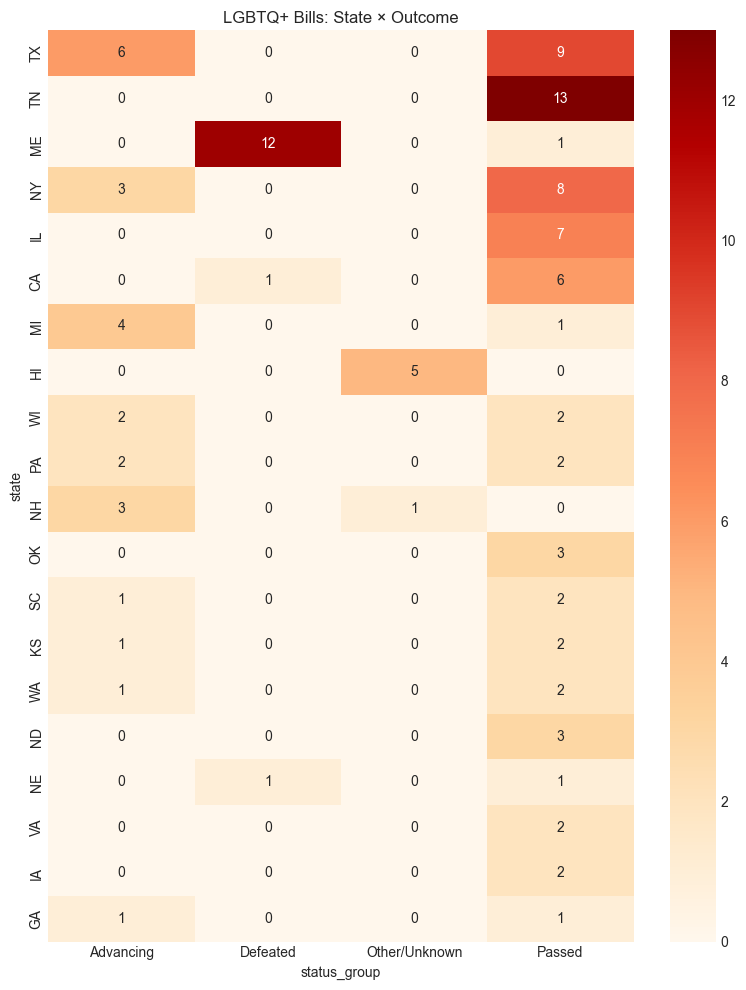

In [17]:
pivot = pd.crosstab(lgbtq_bills['state'], lgbtq_bills['status_group'])
pivot = pivot.loc[pivot.sum(axis=1).sort_values(
    ascending=False).head(20).index]

plt.figure(figsize=(8, 10))
sns.heatmap(pivot, annot=True, fmt='d', cmap='OrRd')
plt.title('LGBTQ+ Bills: State × Outcome')
plt.tight_layout()
plt.show()

In [18]:
# Ouput potential LGBTQ+ bills for inspection
lgbtq_bills[['state', 'bill_number', 'status_group', 'title',
             'description']].to_csv('lgbtq_bills_flagged.csv', index=False)